# PROJECT
### NEVOLIN DMITRY
### 28.10.2023

In [1]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
#os.listdir()

In [3]:
with open('reviews.json', 'r', encoding='utf-8') as f:
    mydata = json.load(f)

In [4]:
data = pd.DataFrame.from_dict(mydata['paper'])

In [5]:
data.head()

,id,preliminary_decision,review
0,1,accept,"[{'confidence': '4', 'evaluation': '1', 'id': ..."
1,2,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
2,3,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
3,4,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."
4,5,accept,"[{'confidence': '4', 'evaluation': '2', 'id': ..."


In [6]:
data.shape

(172, 3)

In [7]:
df = pd.DataFrame(data.review[0])

for i in data.review[1:len(data.review)]:
    el = pd.DataFrame(i)
    df = pd.concat([df, el])

In [8]:
df.index = [i for i in range(df.shape[0])]

df = df[['evaluation', 'lan', 'text']]

df

,evaluation,lan,text
0,1,es,- El artículo aborda un problema contingente y...
1,1,es,El artículo presenta recomendaciones prácticas...
2,1,es,- El tema es muy interesante y puede ser de mu...
3,2,es,Se explica en forma ordenada y didáctica una e...
4,2,es,
...,...,...,...
400,-1,es,El trabajo pretende ofrecer una visión del uso...
401,-1,es,El paper está bien escrito y de fácil lectura....
402,-1,es,Observación de fondo: No se presenta un ejemp...
403,1,es,Se propone un procedimiento para elaborar máqu...


In [9]:
df.query('text == ""')

,evaluation,lan,text
4,2,es,
40,0,es,
45,2,es,
67,2,es,
70,1,es,
108,0,es,


In [10]:
df1 = df.drop(df.query('text == ""').index.to_list(), axis=0).\
reset_index().drop('index', axis=1)

df1

,evaluation,lan,text
0,1,es,- El artículo aborda un problema contingente y...
1,1,es,El artículo presenta recomendaciones prácticas...
2,1,es,- El tema es muy interesante y puede ser de mu...
3,2,es,Se explica en forma ordenada y didáctica una e...
4,2,es,Los autores describen una metodología para des...
...,...,...,...
394,-1,es,El trabajo pretende ofrecer una visión del uso...
395,-1,es,El paper está bien escrito y de fácil lectura....
396,-1,es,Observación de fondo: No se presenta un ejemp...
397,1,es,Se propone un procedimiento para elaborar máqu...


In [11]:
df1.isna().sum()

evaluation    0
lan           0
text          0
dtype: int64

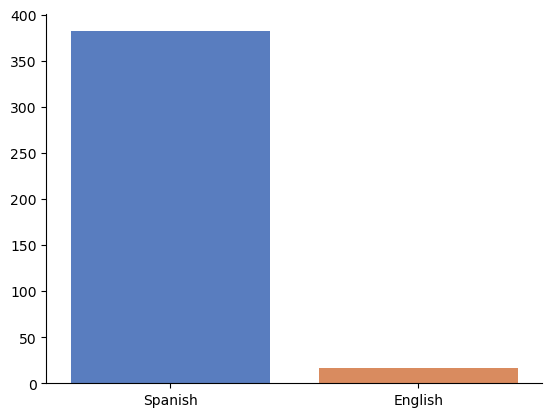

In [12]:
ax = sns.countplot(x='lan', data=df1,
             palette='muted')
sns.despine()
ax.set_xticklabels(['Spanish', 'English'])
plt.xlabel('')
plt.ylabel('')
plt.show()

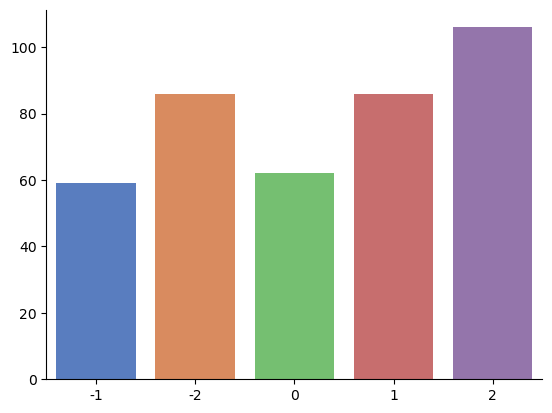

In [13]:
ax = sns.countplot(x='evaluation', data=df1,
             palette='muted', order = df.evaluation.value_counts().sort_index().index)
sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.show()

In [14]:
import spacy
import re
import tqdm
import time

## Working with Spanish

In [15]:
df1_es = df1.query('lan == "es"')['text']

In [16]:
df1_es

0      - El artículo aborda un problema contingente y...
1      El artículo presenta recomendaciones prácticas...
2      - El tema es muy interesante y puede ser de mu...
3      Se explica en forma ordenada y didáctica una e...
4      Los autores describen una metodología para des...
                             ...                        
394    El trabajo pretende ofrecer una visión del uso...
395    El paper está bien escrito y de fácil lectura....
396    Observación de fondo:  No se presenta un ejemp...
397    Se propone un procedimiento para elaborar máqu...
398    El artículo describe básicamente los component...
Name: text, Length: 382, dtype: object

In [17]:
#!python -m spacy download es_core_news_sm

In [18]:
nlp = spacy.load('es_core_news_sm')

In [19]:
lemma_data = []

start = time.time()

for i in tqdm.tqdm(df1_es):
    s = re.sub(r"[«,».¿“/@#?$12-34-5678:;90#—ツ►๑۩۞۩•\n*”˜˜”*°°*`)(]", '', i)
    
    doc = nlp(s)
    
    ls = [i.lemma_ for i in doc if not i.is_stop and i.lemma_ not in [' ', '-', '   ', '"', '[', ']']]
    
    text = ' '.join(ls)
    
    text = text.strip()
    
    lemma_data.append(text)
    
finish = time.time()

print(finish - start, 'sec')

100%|██████████| 382/382 [00:17<00:00, 22.44it/s]

17.029375553131104 sec


In [20]:
lemma_data[0]

'artículo abordar problema contingente relevante incluir diagnóstico nacional práctica solución práctica concreto lenguaje adecuado artículo sentir concatenación artículo resultado encuesta práctica seguridad incorporación práctica orden sección reflejar orden versión revisado artículo validación tipo siquiera evaluación experto'

In [21]:
len(lemma_data)

382

In [25]:
unique_ls = []

for i in lemma_data:
    for j in i.split():
        if j in unique_ls:
            continue
        else:
            unique_ls.append(j)

In [27]:
import fasttext
import fasttext.util

In [28]:
ft = fasttext.load_model('cc.es.300.bin')
fasttext.util.reduce_model(ft, 100) #fasttext model for Spanish

In [29]:
ft_en = fasttext.load_model('cc.en.300.bin')
fasttext.util.reduce_model(ft_en, 100) #fasttext model for English

In [30]:
embeddings_index = {}

for i in unique_ls:
    embeddings_index[i] = list(ft.get_word_vector(i))

In [31]:
len(embeddings_index)

4802

In [33]:
#embedding metrix for Spanish

np.random.seed(100)

embedding_matrix = np.zeros((4000, 100))
j=0
for word, i in embeddings_index.items():
    j=j+1
    if j < 4000:
        embedding_vector = embeddings_index.get(word)
    #print(embedding_vector)
        if embedding_vector is not None:
            embedding_matrix[j] = embedding_vector
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01995155,  0.0208835 , -0.03504385, ...,  0.02915002,
         0.03614547,  0.01691689],
       [ 0.10744479, -0.02492733,  0.05492505, ..., -0.0146158 ,
         0.01578883, -0.01382954],
       ...,
       [-0.20483492,  0.22830248, -0.14993092, ...,  0.08563478,
        -0.15102233,  0.11457791],
       [ 0.11073396, -0.09704914, -0.04307068, ..., -0.03177505,
        -0.00728891, -0.01824209],
       [ 0.08065788, -0.01313456,  0.0398618 , ..., -0.00621988,
        -0.03003248,  0.03173293]])

### Working with English

In [34]:
df1_en = df1.query('lan == "en"')['text']

df1_en

6      This paper aims to show new deployment alterna...
7      The paper is well structured. It follows a log...
18     The paper describes an experience concerning t...
19     This manuscript addresses an interesting solut...
20     Interesting application domain.  Nothing new f...
29     This paper presents a software tool that is us...
45     This paper is very interesting, I like the ide...
73     I don't think the work reported in this paper ...
83     Abstract: Needs to have a definition of ERP - ...
94     The paper introduces a segmentation procedure ...
96     The paper presents a medical test based on ima...
152    This is a developed application to support inf...
303    •I recommend to change the paper title in orde...
350    The authors made an exhaustive study on public...
360    This work gives expected results and creates a...
361    This is an interesting article, present develo...
378    this paper applies an advanced algorithm to ga...
Name: text, dtype: object

In [35]:
nlp_en = spacy.load('en_core_web_sm')

In [36]:
lemma_data_en = []

start = time.time()

for i in tqdm.tqdm(df1_en):
    s = re.sub(r"[«,».“/@#$12-34-5678:;90#—ツ►๑۩۞۩•\n*”˜˜”*°°*`)(]", '', i)
    
    doc = nlp_en(s)
    
    ls = [i.lemma_ for i in doc if not i.is_stop and i.lemma_ not in [' ', '-', '   ', '"']]
    
    text = ' '.join(ls)
    
    text = text.strip()
    
    lemma_data_en.append(text)
    
finish = time.time()

print(finish - start, 'sec')

100%|██████████| 17/17 [00:01<00:00, 15.99it/s]

1.0670740604400635 sec


In [37]:
lemma_data_en[0]

'paper aim new deployment alternative recommender system end author use variation CHC genetic algorithm good job clear detailed inconsistency notation improve formula notation different rest equation point figure refer perfil pesos euclidiana vecindad word relate text think result show graph useful show table'

In [38]:
len(lemma_data_en)

17

## Padded Sequence for both Languages Together

In [39]:
lemma_data.extend(lemma_data_en)

In [40]:
len(lemma_data)

399

In [42]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [43]:
max_words = 1000
tokenizer = Tokenizer(num_words = max_words)

In [44]:
tokenizer.fit_on_texts(lemma_data)

In [45]:
word_index = tokenizer.word_index

In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(lemma_data)

In [47]:
my_max_len = 500
# align the documents to the specified value
padded_seq = pad_sequences(sequences, maxlen=my_max_len, 
                       padding='post', truncating='post')
padded_seq.shape

(399, 500)

In [48]:
y_dummy_es = pd.get_dummies(df1.query('lan == "es"')['evaluation'])
y_dummy_en = pd.get_dummies(df1.query('lan == "en"')['evaluation'])
y_dummy = pd.concat((y_dummy_es, y_dummy_en), axis=0)

y_dummy

,-1,-2,0,1,2
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
303,0,0,0,1,0
350,0,0,0,0,1
360,0,0,0,1,0
361,0,0,0,0,1


## Embedding Metrix for English

In [49]:
unique_ls_en = []

for i in lemma_data_en:
    for j in i.split():
        if j in unique_ls_en:
            continue
        else:
            unique_ls_en.append(j)

In [50]:
#unique_ls_en

In [51]:
embeddings_index_en = {}

for i in unique_ls_en:
    embeddings_index_en[i] = list(ft_en.get_word_vector(i))

In [52]:
#embeddings_index_en

In [53]:
np.random.seed(100)

embedding_matrix_en = np.zeros((4000, 100))
j=0
for word, i in embeddings_index_en.items():
    j=j+1
    if j < 4000:
        embedding_vector = embeddings_index_en.get(word)
    
        if embedding_vector is not None:
            embedding_matrix_en[j] = embedding_vector
embedding_matrix_en

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0541047 , -0.09091075, -0.02431294, ..., -0.11800613,
         0.02951474,  0.09635747],
       [ 0.27856457, -0.21542451, -0.03042078, ...,  0.12015723,
         0.059674  ,  0.08752801],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
#concatenating embedding metrixes

In [54]:
final_embedding_matrix = np.vstack((embedding_matrix, embedding_matrix_en))

final_embedding_matrix.shape

(8000, 100)

## Resampling

In [55]:
new_df = pd.DataFrame(padded_seq)
new_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,2,211,10,104,80,549,700,155,71,155,...,0,0,0,0,0,0,0,0,0,0
1,2,3,704,156,8,22,705,32,155,130,...,0,0,0,0,0,0,0,0,0,0
2,24,13,291,280,155,175,73,79,237,155,...,0,0,0,0,0,0,0,0,0,0
3,67,30,907,139,803,551,711,1,375,804,...,0,0,0,0,0,0,0,0,0,0
4,14,32,36,130,30,403,193,55,8,22,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,27,27,121,546,45,546,166,374,374,90,...,0,0,0,0,0,0,0,0,0,0
395,609,372,699,400,400,584,995,609,400,699,...,0,0,0,0,0,0,0,0,0,0
396,349,401,599,400,372,197,27,400,699,89,...,0,0,0,0,0,0,0,0,0,0
397,904,787,698,118,400,904,799,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
new_labels = list(df1.query('lan == "es"')['evaluation'])

new_labels.extend(list(df1.query('lan == "en"')['evaluation']))

new_df['labels'] = new_labels

new_df

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,labels
0,2,211,10,104,80,549,700,155,71,155,...,0,0,0,0,0,0,0,0,0,1
1,2,3,704,156,8,22,705,32,155,130,...,0,0,0,0,0,0,0,0,0,1
2,24,13,291,280,155,175,73,79,237,155,...,0,0,0,0,0,0,0,0,0,1
3,67,30,907,139,803,551,711,1,375,804,...,0,0,0,0,0,0,0,0,0,2
4,14,32,36,130,30,403,193,55,8,22,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,27,27,121,546,45,546,166,374,374,90,...,0,0,0,0,0,0,0,0,0,1
395,609,372,699,400,400,584,995,609,400,699,...,0,0,0,0,0,0,0,0,0,2
396,349,401,599,400,372,197,27,400,699,89,...,0,0,0,0,0,0,0,0,0,1
397,904,787,698,118,400,904,799,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [57]:
data_two = new_df.query('labels == "2"')
data_one = new_df.query('labels == "1"')
data_zero = new_df.query('labels == "0"')
data_minus_one = new_df.query('labels == "-1"')
data_minus_two = new_df.query('labels == "-2"')

In [58]:
new_df.labels.value_counts()

2     106
1      86
-2     86
0      62
-1     59
Name: labels, dtype: int64

In [60]:
from sklearn.utils import resample

In [124]:
np.random.seed(100)

print('before sampling: ', data_two.shape)

data_two_sample = resample(data_two,
             replace=True,
             n_samples=150,
             random_state=5)

print('after sampling: ', data_two_sample.shape)

before sampling:  (106, 501)
after sampling:  (150, 501)


In [125]:
np.random.seed(100)

print('before sampling: ', data_one.shape)

data_one_sample = resample(data_one,
             replace=True,
             n_samples=150,
             random_state=5)

print('after sampling: ', data_one_sample.shape)

before sampling:  (86, 501)
after sampling:  (150, 501)


In [126]:
np.random.seed(100)

print('before sampling: ', data_minus_two.shape)

data_minus_two_sample = resample(data_minus_two,
             replace=True,
             n_samples=150,
             random_state=5)

print('after sampling: ', data_minus_two_sample.shape)

before sampling:  (86, 501)
after sampling:  (150, 501)


In [127]:
np.random.seed(100)

print('before sampling: ', data_zero.shape)

data_zero_sample = resample(data_zero,
             replace=True,
             n_samples=150,
             random_state=5)

print('after sampling: ', data_zero_sample.shape)

before sampling:  (62, 501)
after sampling:  (150, 501)


In [128]:
np.random.seed(100)

print('before sampling: ', data_minus_one.shape)

data_minus_one_sample = resample(data_minus_one,
             replace=True,
             n_samples=150,
             random_state=5)

print('after sampling: ', data_minus_one_sample.shape)

before sampling:  (59, 501)
after sampling:  (150, 501)


In [129]:
full_sample = pd.concat([data_two_sample, data_one_sample, data_minus_two_sample, data_zero_sample,
                                     data_minus_one_sample], axis=0).reset_index()
print(full_sample.shape)

(750, 502)


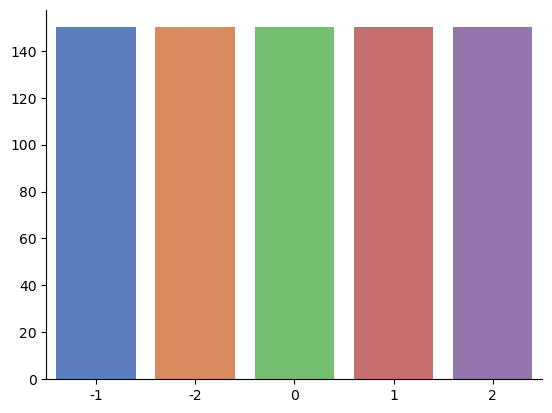

In [130]:
ax = sns.countplot(x='labels', data=full_sample,
             palette='muted', order = full_sample.labels.value_counts().sort_index().index)
sns.despine()
plt.xlabel('')
plt.ylabel('')
plt.show()

In [105]:
from sklearn.utils import shuffle

np.random.seed(100)

resulted_data = shuffle(full_sample)

In [106]:
y = resulted_data.labels
y_dummy = pd.get_dummies(y)
y_dummy

,-1,-2,0,1,2
133,0,0,0,0,1
479,0,1,0,0,0
779,1,0,0,0,0
341,0,1,0,0,0
114,0,0,0,0,1
...,...,...,...,...,...
350,0,1,0,0,0
79,0,0,0,0,1
835,1,0,0,0,0
792,1,0,0,0,0


In [107]:
del resulted_data['index']
del resulted_data['labels']

In [108]:
resulted_data.shape

(850, 500)

## Model Building

In [71]:
from tensorflow.keras.callbacks import EarlyStopping

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops learning when the
    validation (testing) accuracy has not improved over the last N epochs.
    """
    
    early_stopping=EarlyStopping(monitor='val_loss',mode='min', patience=1)
    
    return early_stopping

early_stopping = get_early_stopping()

callbacks = [early_stopping]

In [72]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization

In [74]:
np.random.seed(100)

model = Sequential()
model.add(Embedding(8000, 100, input_length=500))

model.add(Flatten()) # dimension conversion

model.add(Dense(64, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(BatchNormalization(axis=1))

model.add(Dense(5, activation='softmax'))
model.summary()

model.layers[0].set_weights([final_embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 100)          800000    
                                                                 
 flatten_1 (Flatten)         (None, 50000)             0         
                                                                 
 dense_1 (Dense)             (None, 64)                3200064   
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                      

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
np.random.seed(100)

x_train, x_valid, y_train, y_valid = train_test_split(resulted_data, y_dummy, test_size=0.2)

In [78]:
history = model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_valid, y_valid),
                   callbacks=callbacks)

Epoch 1/20
2/2 [==============================] - 16s 8s/step - loss: 1.6176 - accuracy: 0.2317 - val_loss: 1.5628 - val_accuracy: 0.4533
Epoch 2/20
2/2 [==============================] - 6s 6s/step - loss: 0.9887 - accuracy: 0.6550 - val_loss: 1.5066 - val_accuracy: 0.6267
Epoch 3/20
2/2 [==============================] - 3s 3s/step - loss: 0.5442 - accuracy: 0.9000 - val_loss: 1.4685 - val_accuracy: 0.7400
Epoch 4/20
2/2 [==============================] - 3s 3s/step - loss: 0.3442 - accuracy: 0.9300 - val_loss: 1.4428 - val_accuracy: 0.7667
Epoch 5/20
2/2 [==============================] - 3s 3s/step - loss: 0.2058 - accuracy: 0.9800 - val_loss: 1.4151 - val_accuracy: 0.8467
Epoch 6/20
2/2 [==============================] - 3s 3s/step - loss: 0.1303 - accuracy: 0.9900 - val_loss: 1.3903 - val_accuracy: 0.8533
Epoch 7/20
2/2 [==============================] - 3s 3s/step - loss: 0.0845 - accuracy: 0.9950 - val_loss: 1.3808 - val_accuracy: 0.8533
Epoch 8/20
2/2 [========================

In [79]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

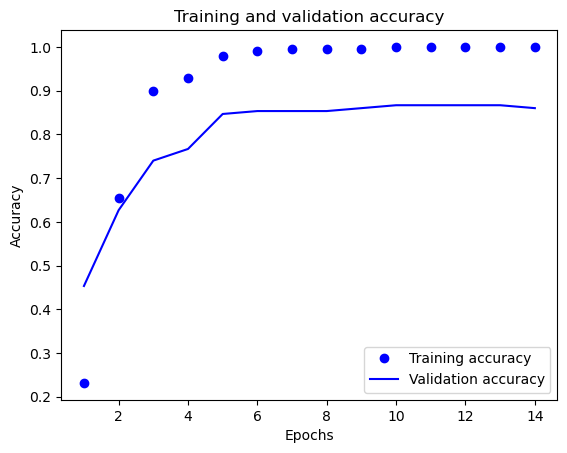

In [81]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [82]:
predictions = model.predict(x_valid)

print(predictions.shape)

5/5 [==============================] - 7s 8ms/step
(150, 5)


In [83]:
y_preds = np.argmax(predictions, axis=1).tolist()
for n in range(len(y_preds)):
    if y_preds[n]==4: y_preds[n]='2'
    if y_preds[n]==3: y_preds[n]='1'
    if y_preds[n]==2: y_preds[n]='0'
    if y_preds[n]==1: y_preds[n]='-2'
    if y_preds[n]==0: y_preds[n]='-1'

yy = y_valid.idxmax(axis=1)

In [87]:
from sklearn.metrics import classification_report

In [89]:
print(classification_report(y_preds, yy))

              precision    recall  f1-score   support

          -1       1.00      0.65      0.79        40
          -2       0.79      0.96      0.87        24
           0       0.77      0.96      0.86        28
           1       0.94      0.91      0.92        32
           2       0.83      0.92      0.87        26

    accuracy                           0.86       150
   macro avg       0.87      0.88      0.86       150
weighted avg       0.88      0.86      0.86       150



## Cross-Validation

In [90]:
from sklearn.model_selection import KFold

In [91]:
np.random.seed(100)

kfold = KFold(n_splits=3, shuffle=True, random_state=100)

In [119]:
acc_list = []

m_ls = []

fold = 1

In [120]:
Y = y_dummy.to_numpy()

X = resulted_data.to_numpy()

In [121]:
def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops learning when the
    validation (testing) accuracy has not improved over the last N epochs.
    """
    
    early_stopping=EarlyStopping(monitor='loss',mode='min', patience=1)
    
    return early_stopping

early_stopping = get_early_stopping()

callbacks = [early_stopping]

In [122]:
np.random.seed(100)

for train, valid in kfold.split(X, Y):
    
    train_x = X[train]
    
    valid_x = X[valid]
    
    model2 = Sequential()
    model2.add(Embedding(8000, 100, input_length=500))

    model2.add(Flatten()) # dimension conversion
    model2.add(Dense(64, activation='relu'))
    model2.add(Dense(64, activation='relu'))
    model2.add(Dense(64, activation='relu'))
    model2.add(BatchNormalization(axis=1))
    model2.add(Dense(5, activation='softmax'))
    model2.summary()

    model2.layers[0].set_weights([final_embedding_matrix])
    model2.layers[0].trainable = False # False - means that the layer is frozen

    model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model2.fit(train_x, Y[train], epochs=20, batch_size=512,
                   callbacks=callbacks)
    
    score = model2.evaluate(valid_x, Y[valid], verbose=0)
    
    acc_list.append(score[1] * 100)
    
    fold +=1

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 500, 100)          800000    
                                                                 
 flatten_12 (Flatten)        (None, 50000)             0         
                                                                 
 dense_45 (Dense)            (None, 64)                3200064   
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_11 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                     

In [123]:
for i in acc_list:
    print(i)

81.69013857841492
82.33215808868408
79.85865473747253


# -----------------------------------------------------------------------------------------